In [46]:
import pandas as pd
data = pd.read_csv("billboard_impact.csv")

In [47]:
data.head()

,month,deposits,aver_inc,population,manprop,billboard,numofbank
0,4,42,5239.0,9451.0,42.0,1,18.0
1,1,0,5705.0,9984.0,42.0,1,17.0
2,5,52,4391.0,12065.0,60.0,1,18.0
3,3,119,6105.0,14481.0,43.0,1,20.0
4,2,21,5820.0,19937.0,40.0,1,8.0


In [48]:
data[data['month'] <= 6]

,month,deposits,aver_inc,population,manprop,billboard,numofbank
0,4,42,5239.0,9451.0,42.0,1,18.0
1,1,0,5705.0,9984.0,42.0,1,17.0
2,5,52,4391.0,12065.0,60.0,1,18.0
3,3,119,6105.0,14481.0,43.0,1,20.0
4,2,21,5820.0,19937.0,40.0,1,8.0
...,...,...,...,...,...,...,...
2595,3,156,3710.0,17185.0,44.0,0,17.0
2596,1,308,5005.0,5373.0,45.0,0,15.0
2597,2,258,4094.0,18590.0,58.0,0,17.0
2598,1,152,4312.0,16675.0,58.0,0,13.0


In [49]:
data['post'] = data['month'].apply(lambda x: 1 if x >= 7 else 0)

import statsmodels.formula.api as smf

# Run a DID regression without control variables
did_model = smf.ols('deposits ~ billboard * post', data=data).fit()

did_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               deposits   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     696.7
Date:                Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:04:30   Log-Likelihood:                -26973.
No. Observations:                4600   AIC:                         5.395e+04
Df Residuals:                    4596   BIC:                         5.398e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        171.6423      2.363     72.625      0.000     167.009     176.276
billboard       -125.6263      4.484    -28.015      0.000    -134.418    -116.835
post              34.5232      3.036     11.372      0.000      28.571      40.475
billboard:post     6.5246      5.729      1.139      0.255      -4.706      17.755
==============================================================================
Omnibus:                      184.879   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.379
Skew:                          -0.400   Prob(JB):                     1.29e-56
Kurtosis:                       3.838   Cond. No.                         7.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# Run a DID regression with control variables (aver_inc, population, numofbank)
did_model_with_controls = smf.ols(
    'deposits ~ billboard * post + aver_inc + population + numofbank', 
    data=data
).fit()

did_model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               deposits   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     348.3
Date:                Tue, 07 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:04:34   Log-Likelihood:                -26906.
No. Observations:                4589   AIC:                         5.383e+04
Df Residuals:                    4582   BIC:                         5.387e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        163.7762      9.443     17.344      0.000     145.264     182.289
billboard       -124.5415      5.115    -24.346      0.000    -134.570    -114.513
post              34.6617      3.037     11.412      0.000      28.707      40.616
billboard:post     6.7941      5.751      1.181      0.237      -4.480      18.068
aver_inc          -0.0008      0.002     -0.496      0.620      -0.004       0.002
population         0.0004      0.000      1.463      0.144      -0.000       0.001
numofbank          0.5044      0.272      1.851      0.064      -0.030       1.039
==============================================================================
Omnibus:                      183.514   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.667
Skew:                          -0.400   Prob(JB):                     5.01e-56
Kurtosis:                       3.832   Cond. No.                     1.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

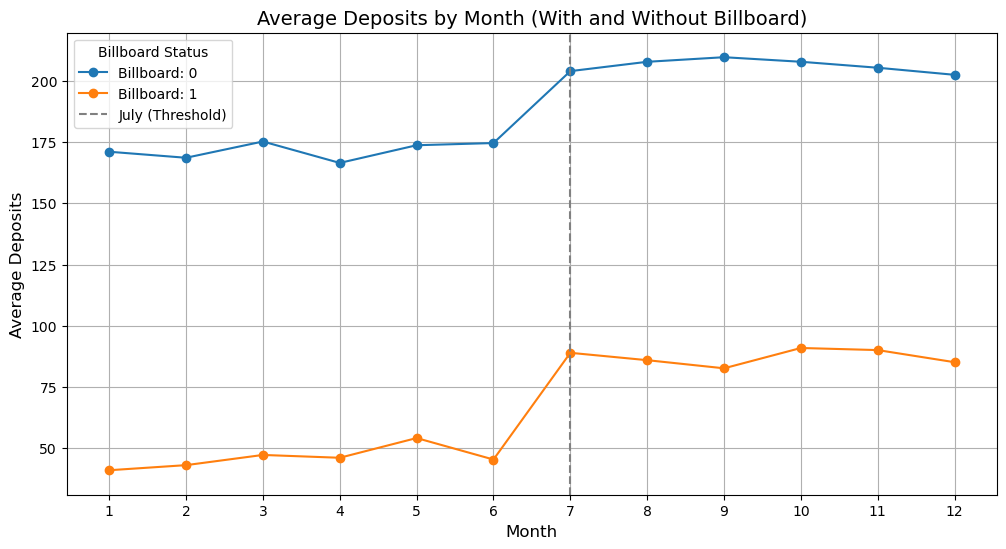

In [51]:
# Graphically check parallel trend
import matplotlib.pyplot as plt

trend_data = data.groupby(['month', 'billboard'])['deposits'].mean().reset_index()


plt.figure(figsize=(12, 6))

for billboard, group_data in trend_data.groupby('billboard'):
    plt.plot(group_data['month'], group_data['deposits'], marker='o', label=f"Billboard: {billboard}")


plt.axvline(x=7, color='gray', linestyle='--', label="July (Threshold)")
plt.ylim(trend_data['deposits'].min() - 10, trend_data['deposits'].max() + 10)
plt.title("Average Deposits by Month (With and Without Billboard)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Deposits", fontsize=12)
plt.xticks(range(trend_data['month'].min(), trend_data['month'].max() + 1))
plt.grid(True)
plt.legend(title="Billboard Status")
plt.show()

In [52]:
# Numerically check parallel trend

import numpy as np

group_means = data.groupby(['billboard', 'post'])['deposits'].mean().reset_index()

treated_pre = group_means[(group_means['billboard'] == 1) & (group_means['post'] == 0)]['deposits'].values[0]
untreated_pre = group_means[(group_means['billboard'] == 0) & (group_means['post'] == 0)]['deposits'].values[0]
untreated_post = group_means[(group_means['billboard'] == 0) & (group_means['post'] == 1)]['deposits'].values[0]
treated_post = group_means[(group_means['billboard'] == 1) & (group_means['post'] == 1)]['deposits'].values[0]

# Counterfactual trend calculation
untreated_change = untreated_post - untreated_pre
counterfactual_trend = treated_pre + untreated_change

# Difference between actual and counterfactual trends
difference = treated_post - counterfactual_trend

results = {
    "Treated Pre-Treatment Mean": treated_pre,
    "Untreated Pre-Treatment Mean": untreated_pre,
    "Untreated Post-Treatment Mean": untreated_post,
    "Untreated Change": untreated_change,
    "Counterfactual Trend": counterfactual_trend,
    "Actual Treated Post-Treatment Mean": treated_post,
    "Difference (Actual - Counterfactual)": difference,
}

from scipy.stats import ttest_ind

pre_treatment = data[data['post'] == 0]
treated_trend = pre_treatment[pre_treatment['billboard'] == 1]['deposits']
untreated_trend = pre_treatment[pre_treatment['billboard'] == 0]['deposits']

t_stat, p_value = ttest_ind(treated_trend, untreated_trend)

results["T-test Statistic"] = t_stat
results["P-value"] = p_value

results

{'Treated Pre-Treatment Mean': 46.016,
 'Untreated Pre-Treatment Mean': 171.6423076923077,
 'Untreated Post-Treatment Mean': 206.1655,
 'Untreated Change': 34.52319230769231,
 'Counterfactual Trend': 80.5391923076923,
 'Actual Treated Post-Treatment Mean': 87.06375,
 'Difference (Actual - Counterfactual)': 6.524557692307695,
 'T-test Statistic': -30.06013563063022,
 'P-value': 3.4572840709727914e-161}

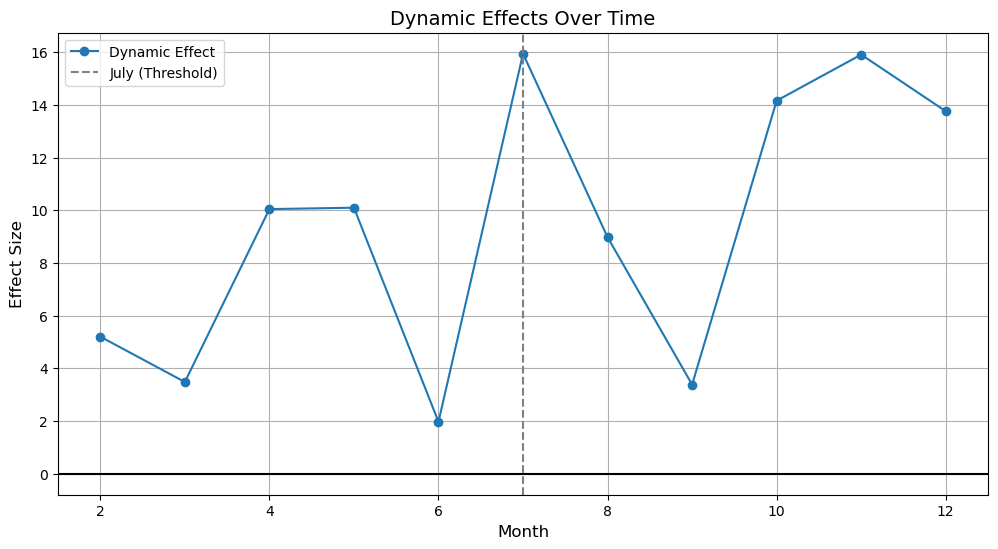

In [53]:
# Dynamic effect

data['time'] = data['month'].astype('category')

model = smf.ols(
    formula='deposits ~ billboard * time + aver_inc + population + numofbank',
    data=data
).fit()

# Extract coefficients for billboard-time interaction terms
dynamic_effects = model.params.filter(like='billboard:time')

plt.figure(figsize=(12, 6))
plt.plot(
    dynamic_effects.index.str.extract(r'(\d+)')[0].astype(int),  # Extract time values
    dynamic_effects.values, marker='o', label="Dynamic Effect"
)
plt.axvline(x=7, color='gray', linestyle='--', label="July (Threshold)")
plt.title("Dynamic Effects Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Effect Size", fontsize=12)
plt.axhline(y=0, color='black', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()